In [1]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


In [2]:
!pip install -q spacy

In [3]:
!pip install -q tensorflow

In [4]:
!pip install -q transformers

In [5]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam
import warnings
warnings.filterwarnings('ignore')

## Versão 3 do Modelo - Fine Tuning de Modelo Transformer Pré-Treinado

Usaremos os dados processados com SpaCy e então faremos o processamento específico para o modelo BERT, assim como fizemos com o modelo da versão 1.

In [8]:
#Dados Treino
dados_dsa_treino = pd.read_csv('dados_treino.txt', header = None,delimiter = ';')

In [9]:
#Dados Teste
dados_dsa_teste = pd.read_csv('dados_teste.txt', header = None,delimiter = ';')

In [12]:
#Ajusta nomes colunas
dados_dsa_treino = dados_dsa_treino.rename(columns = {0: 'texto', 1:'sentimento'})
dados_dsa_teste = dados_dsa_teste.rename(columns = {0: 'texto', 1:'sentimento'})

Pré Processamento

In [13]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [14]:
dsa_nlp = spacy.load('en_core_web_md')

In [15]:
# Definição da função 'dsa_preprocessa_texto' que recebe um texto como parâmetro
def dsa_preprocessa_texto(text):
    doc = dsa_nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [16]:
dados_dsa_treino['texto_processado'] = dados_dsa_treino['texto'].apply(dsa_preprocessa_texto)

In [17]:
dados_dsa_teste['texto_processado'] = dados_dsa_teste['texto'].apply(dsa_preprocessa_texto)

In [18]:
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [19]:
# Função para codificar o texto em sequência de inteiros para entrada do modelo BERT
def dsa_encode(texts, tokenizer, chunk_size = 256, maxlen = 512):

    # Ativar truncamento no tokenizador para um comprimento máximo especificado
    tokenizer.enable_truncation(max_length = maxlen)

    # Ativar padding no tokenizador para um comprimento específico
    tokenizer.enable_padding(length = maxlen)

    # Inicializar uma lista para armazenar os IDs codificados
    all_ids = []

    # Iterar sobre os textos em pedaços de tamanho 'chunk_size'
    for i in tqdm(range(0, len(texts), chunk_size)):

        # Criar um pedaço (chunk) do texto
        text_chunk = texts[i:i+chunk_size].tolist()

        # Codificar o pedaço do texto em lote
        encs = tokenizer.encode_batch(text_chunk)

        # Estender a lista 'all_ids' com os IDs codificados
        all_ids.extend([enc.ids for enc in encs])

    # Retorna a lista de IDs como um array numpy
    return np.array(all_ids)

https://huggingface.co/distilbert-base-multilingual-cased

In [20]:
# Carrega o tokenizador do modelo pré-treinado
tokenizador_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [21]:
# Salva o tokenizador e o vocabulário localmente
tokenizador_bert.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [22]:
# Carrega um tokenizador mais veloz usando o vocabulário do tokenizador principal
# from tokenizers import BertWordPieceTokenizer
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

In [23]:
# Visualiza o tokenizador
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [24]:
# Divide os dados em treino e validação com amostragem estratificada
X_treino, X_valid, Y_treino, Y_valid = train_test_split(dados_dsa_treino['texto_processado'].values,
                                                        dados_dsa_treino['sentimento'].values,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        stratify = dados_dsa_treino['sentimento'])

A amostragem estratificada é uma técnica usada em estatística para garantir que subgrupos (ou estratos) de uma população sejam adequadamente representados dentro de uma amostra. É particularmente útil em situações onde a população é heterogênea e os subgrupos têm características diferentes que são importantes para a pesquisa.

In [25]:
# Comprimento máximo usado no texto
max_length = 100

In [26]:
# Aplica a codificação (tokenização) em nossos dados, usando o tokenizador mais veloz
X_treino_final = dsa_encode(X_treino, fast_tokenizer, maxlen = max_length)
X_valid_final = dsa_encode(X_valid, fast_tokenizer, maxlen = max_length)
X_teste_final = dsa_encode(dados_dsa_teste['texto_processado'].to_numpy(), fast_tokenizer, maxlen = max_length)

100%|██████████| 8/8 [00:00<00:00, 87.67it/s]


In [27]:
X_treino_final.shape

(12800, 100)

In [28]:
# Define o encoder dos dados de saída
dsa_le_v3 = LabelEncoder()

In [29]:
# Aplica o codificador (fit_transform somente nos dados de treino)
y_treino_le = dsa_le_v3.fit_transform(Y_treino)
y_valid_le = dsa_le_v3.transform(Y_valid)
y_teste_le = dsa_le_v3.transform(dados_dsa_teste['sentimento'])

In [30]:
# Converte a variável de saída em categórica
y_treino_encoded = to_categorical(y_treino_le)
y_valid_encoded = to_categorical(y_valid_le)
y_teste_encoded = to_categorical(y_teste_le)

In [31]:
# Tamanho do batch
BATCH_SIZE = 16

In [32]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_treino = (tf.data.Dataset
    .from_tensor_slices((X_treino_final, y_treino_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
)

In [33]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_valid = (tf.data.Dataset
    .from_tensor_slices((X_valid_final, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()
)

In [34]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_teste = (
    tf.data.Dataset
    .from_tensor_slices((X_teste_final, y_teste_encoded))
    .batch(BATCH_SIZE)
)

In [35]:
# Função para o ajuste fino e treino do modelo usando um transformador (como BERT)
def dsa_cria_modelo(transformer, max_len = 512):

    # Definindo a camada de entrada com tamanho máximo de sequência
    input_word_ids = tf.keras.layers.Input(shape = (max_len,),
                                           dtype = tf.int32,
                                           name = "input_word_ids")

    # Obtendo a saída da sequência do transformador
    sequence_output = transformer(input_word_ids)[0]

    # Selecionando o primeiro token de cada sequência (token CLS no BERT) para a classificação
    cls_token = sequence_output[:, 0, :]

    # Adicionando uma camada densa para a saída com ativação softmax para classificação
    out = Dense(6, activation = 'softmax')(cls_token)

    # Construindo o modelo Keras com as entradas e saídas definidas
    modelo = tf.keras.Model(inputs = input_word_ids, outputs = out)

    # Compilando o modelo com otimizador Adam, perda de entropia cruzada categórica e métricas de avaliação
    modelo.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy', Precision(), Recall(), AUC()])

    # Retorna o modelo compilado
    return modelo

> Carregando o Modelo Pré-Treinado:

https://huggingface.co/distilbert-base-multilingual-cased

In [36]:
# Cria uma instância do modelo DistilBERT multilíngue, pré-treinado, adequado para uso com TensorFlow
transformer_layer = (transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased'))

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**TFDistilBertModel**: É uma classe dentro da biblioteca transformers. Ela representa o modelo DistilBERT adaptado para TensorFlow. O DistilBERT é uma versão simplificada do BERT que oferece um bom balanço entre desempenho e eficiência. Ele foi treinado para destilar o conhecimento do BERT mantendo a maior parte de sua eficácia, mas com uma arquitetura mais leve e mais rápida para treinamento e inferência.

**from_pretrained**: Este é um método da classe TFDistilBertModel que permite carregar um modelo pré-treinado. Utilizar um modelo pré-treinado permite aproveitar um modelo que já foi treinado em um grande conjunto de dados e aprendeu um bom entendimento da linguagem. Isso é especialmente útil para tarefas de PLN, onde treinar um modelo do zero requer grandes quantidades de dados e poder computacional.

**'distilbert-base-multilingual-cased'**: Este é o identificador do modelo pré-treinado específico que está sendo carregado. Neste caso, é o distilbert-base-multilingual-cased, que é uma versão do DistilBERT que suporta múltiplos idiomas (multilingual) e distingue entre letras maiúsculas e minúsculas (cased). Este modelo foi treinado com textos em vários idiomas, tornando-o útil para aplicações que precisam entender e processar texto em múltiplas línguas.

In [37]:
# Cria o modelo com as camadas do transformador pré-treinado e nossas camadas customizadas para o ajuste fino
modelo_dsa_v3 = dsa_cria_modelo(transformer_layer, max_len = max_length)

In [38]:
# Resumo do modelo
modelo_dsa_v3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 6)                 4614  

In [39]:
# Definindo as primeiras três camadas do modelo como não treináveis
modelo_dsa_v3.layers[0].trainable = False
modelo_dsa_v3.layers[1].trainable = False
modelo_dsa_v3.layers[2].trainable = False

Estes índices acima acessam especificamente a primeira, segunda e terceira camadas do modelo, respectivamente. Em Python, a indexação começa em 0, portanto, layers[0] é a primeira camada, layers[1] é a segunda e assim por diante.

**trainable = False**: Esta instrução define a propriedade trainable da camada especificada para False. Quando uma camada é definida como não treinável, isso significa que seus pesos não serão atualizados durante o treinamento do modelo. Em outras palavras, o estado dessa camada permanecerá o mesmo, independente do processo de aprendizado que o resto do modelo está passando.

Queremos treinar somente a parte final do modelo. Isso é o ajuste fino de modelos pré-treinados.

In [40]:
# Resumo
modelo_dsa_v3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 6)                 4614  

In [41]:
# Hiperparâmetros
n_steps = X_treino_final.shape[0] // BATCH_SIZE
num_epochs = 3

> Treinamento do Modelo.

In [42]:
%%time
history = modelo_dsa_v3.fit(dataset_treino,
                            steps_per_epoch = n_steps,
                            validation_data = dataset_valid,
                            epochs = num_epochs)

Epoch 1/3
800/800 [==============================] - 199s 233ms/step - loss: 1.2213 - accuracy: 0.5149 - precision: 0.7889 - recall: 0.2998 - auc: 0.8423 - val_loss: 0.4760 - val_accuracy: 0.8372 - val_precision: 0.8783 - val_recall: 0.8009 - val_auc: 0.9758
Epoch 2/3
800/800 [==============================] - 174s 218ms/step - loss: 0.3694 - accuracy: 0.8663 - precision: 0.8898 - recall: 0.8440 - auc: 0.9849 - val_loss: 0.3085 - val_accuracy: 0.8850 - val_precision: 0.8959 - val_recall: 0.8772 - val_auc: 0.9892
Epoch 3/3
800/800 [==============================] - 183s 229ms/step - loss: 0.2339 - accuracy: 0.9066 - precision: 0.9194 - recall: 0.8971 - auc: 0.9937 - val_loss: 0.2483 - val_accuracy: 0.9013 - val_precision: 0.9141 - val_recall: 0.8909 - val_auc: 0.9922
CPU times: user 6min 43s, sys: 14.6 s, total: 6min 58s
Wall time: 9min 16s


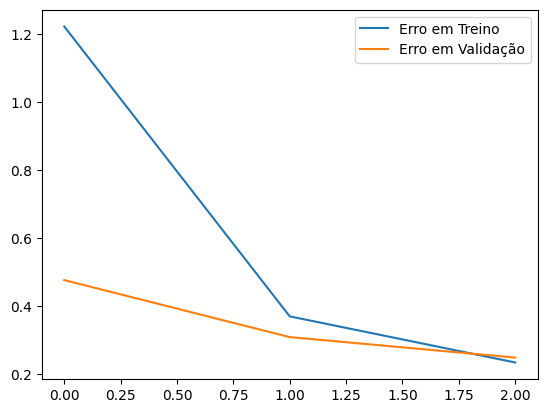

In [43]:
# Curvas de aprendizado
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [44]:
# Previsões
previsoes = modelo_dsa_v3.predict(X_teste_final)

63/63 [==============================] - 8s 104ms/step


In [45]:
# Labels
labels_previstos = previsoes.argmax(axis = 1)

In [46]:
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       275
           1       0.92      0.83      0.87       224
           2       0.94      0.93      0.93       695
           3       0.75      0.86      0.80       159
           4       0.95      0.92      0.94       581
           5       0.70      0.83      0.76        66

    accuracy                           0.91      2000
   macro avg       0.86      0.88      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [47]:
print(confusion_matrix(y_teste_le, labels_previstos))

[[255   2   4   2  12   0]
 [  9 185   3   0   4  23]
 [  3   1 643  41   7   0]
 [  2   1  16 136   4   0]
 [ 18  11  13   2 536   1]
 [  1   2   8   0   0  55]]


In [48]:
print(accuracy_score(y_teste_le, labels_previstos))

0.905


In [49]:
# Salva o modelo no formato do TensorFlow
modelo_dsa_v3.save("modelo_dsa_v3.keras", save_format = 'tf')

> Deploy do Modelo.

Nota: O TensorFlow não reconhece automaticamente camadas personalizadas ou objetos que não fazem parte do núcleo do Keras/TensorFlow, como é o caso do TFDistilBertModel do pacote transformers.

Para resolver isso, você precisa registrar a camada personalizada (neste caso, TFDistilBertModel) antes de carregar o modelo, conforme abaixo:

In [50]:
# Carregando o modelo

# Imports
from transformers import TFDistilBertModel
from tensorflow.keras.utils import custom_object_scope

# Registra camada personalizada e carrega o modelo
with custom_object_scope({'TFDistilBertModel': TFDistilBertModel}):
    modelo_recarregado = tf.keras.models.load_model("modelo_dsa_v3.keras")

In [51]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [52]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [53]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [54]:
novos_dados = dsa_encode(df_novo['Frase_Processada'], fast_tokenizer, maxlen = max_length)

100%|██████████| 1/1 [00:00<00:00, 1446.31it/s]


In [55]:
# Fazer previsões com o modelo carregado
previsoes = modelo_recarregado.predict(novos_dados)

1/1 [==============================] - 1s 1s/step


In [56]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [57]:
classe_maior_prob

array([1])

In [58]:
# Obtém o nome da classe
nome_classe = dsa_le_v3.inverse_transform(classe_maior_prob)

In [59]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)

In [60]:
# Desliga o paralelismo do pacote Transformer
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false
